<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep convolutional net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an IPython notebook via Learning Suite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 20% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracies
* 10% Reach 85% validation accuracy from parts 1-3
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

* Watch tutorial

**DONE:**

In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import math

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [3]:
# Use the dataset class you created in lab2

class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root, train=train, transform=transforms.ToTensor(), download=True)

  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y

  def __len__(self):
    return len(self.data)
    

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropyLoss function. Do not use PyTorch's implementation of cross entropy loss (F.cross_entropy or nn.CrossEntropyLoss) for your re-implementation of cross entropy loss. You may use PyTorch's functional implemenation of 2D convolution in your Conv2D module.

**TODO:**

* CrossEntropyLoss 
* Conv2D

**DONE:**

___

### Part 2
Implement three initialization strategies: Xe initialization
(sometimes called Xavier), orthogonal initialization, and uniform random initialization.
You can specify which strategy you want to use with a parameter.



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform

**DONE:**



In [54]:
class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100, 
               reduce=None, reduction='mean'):
    self.__dict__.update(locals())
    super(CrossEntropyLoss, self).__init__()

  def forward(self, input, target):
    list1 = []
    for i in range(len(target)):
      list1.append(input[i][target[i]])
    return torch.mean(torch.subtract(torch.logsumexp(input, 1), torch.Tensor(list1).cuda(non_blocking=True)))
    


class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, 
               padding=0, dilation=1, groups=1, bias=True, 
               padding_mode='zeros', device=None, dtype=None, initialization=1):
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()

    self.weight = Parameter(torch.Tensor(self.out_channels, 
                                         self.in_channels, 
                                         self.kernel_size[0], 
                                         self.kernel_size[1]))
    self.bias = Parameter(torch.Tensor(self.out_channels))

    if self.initialization == 2:
      # self.weight.data.uniform_(-1/math.sqrt(self.in_channels), 1/math.sqrt(self.in_channels))
      self.weight.data.uniform_(-2/self.in_channels, 2/self.in_channels)
      self.bias.data.uniform_(2/self.in_channels, 2/self.in_channels)
      #initialize with Xe
    elif self.initialization == 3:
      flat_shape = (self.out_channels, np.prod([self.in_channels, 
                                                self.kernel_size[0], 
                                                self.kernel_size[1]]))
      a = np.random.normal(0, 1, flat_shape).astype(np.float32)
      u, _, v = np.linalg.svd(a, full_matrices=False)
      q = u if u.shape == flat_shape else v
      q = q.reshape(self.out_channels, 
                    self.in_channels, 
                    self.kernel_size[0], 
                    self.kernel_size[1])
      self.bias.data.uniform_(0, 0)
      #initialize with Orthogonality
    else:
      self.weight.data.uniform_(-1, 1)
      self.bias.data.uniform_(1, 1)


  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, 
                    self.padding, self.dilation, self.groups)


In [62]:
class ConvNetwork(nn.Module):
  def __init__(self, dataset, initialization=1):
    super(ConvNetwork, self).__init__()
    self.initialization=initialization
    x, y = dataset[0]
    c, h, w = x.size()
    output = 10

    self.net = nn.Sequential(
        Conv2d(c, 10, (3, 3), padding=(1, 1), initialization=self.initialization),
        nn.ReLU(),
        Conv2d(10, 10, (3, 3), padding=(1, 1), initialization=self.initialization),
        nn.ReLU(),
        Conv2d(10, output, (28, 28), padding=(0, 0), initialization=self.initialization)
    )

  def forward(self, x):
      return self.net(x).squeeze(2).squeeze(2)


In [77]:
# Initialize Datasets

train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

# Initialize DataLoaders

train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True)
validation_loader = DataLoader(val_dataset, batch_size=42, pin_memory=True)

# Initialize Model

model = ConvNetwork(train_dataset)
model = model.cuda()
modelXe = ConvNetwork(train_dataset, initialization=2)
modelXe = modelXe.cuda()
modelOr = ConvNetwork(train_dataset, initialization=3)
modelOr = modelOr.cuda() 

# Initialize Objective and Optimizer and other parameters

objective = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizerXe = optim.Adam(modelXe.parameters(), lr=1e-4)
optimizerOr = optim.Adam(modelOr.parameters(), lr=1e-4)


In [82]:

# Run your training and validation loop and collect stats

train_losses = []
validation_losses = []
train_accuracy = []
validation_accuracy = []

train_lossesXe = []
validation_lossesXe = []
train_accuracyXe = []
validation_accuracyXe = []

train_lossesOr = []
validation_lossesOr = []
train_accuracyOr = []
validation_accuracyOr = []

num_epochs = 1
loop = tqdm(total=len(train_loader)*num_epochs, position=0, leave=False)
for epoch in range (num_epochs):
  batch = 0
  for batch, (x, y_truth) in enumerate(train_loader):
    x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)

    optimizer.zero_grad()
    y_hat = model(x)
    y_hatXe = modelXe(x)
    y_hatOr = modelOr(x)


    loss = objective(y_hat, y_truth)
    lossXe = objective(y_hatXe, y_truth)
    lossOr = objective(y_hatOr, y_truth)


    loss.backward()
    lossXe.backward()
    lossOr.backward()

    train_losses.append(loss.item())
    train_lossesXe.append(lossXe.item())
    train_lossesOr.append(lossOr.item())
    accuracy = (y_hat.argmax(1) == y_truth).float().mean()
    train_accuracy.append(accuracy)
    accuracyXe = (y_hatXe.argmax(1) == y_truth).float().mean()
    train_accuracyXe.append(accuracyXe)
    accuracyOr = (y_hatOr.argmax(1) == y_truth).float().mean()
    train_accuracyOr.append(accuracyOr)

    loop.set_description('epoch:{} loss:{:.4f} lossXe:{:.4f} lossOr:{:.4f} accuracy:{:.4f} accuracyXe:{:.4f} accuracyOr:{:.4f}'.format(epoch, 
                                                                                                                                       loss.item(), 
                                                                                                                                       lossXe.item(), 
                                                                                                                                       lossOr.item(), 
                                                                                                                                       accuracy, 
                                                                                                                                       accuracyXe,
                                                                                                                                       accuracyOr))
    loop.update(1)

    optimizer.step()
    optimizerXe.step()
    optimizerOr.step()

    if batch % 100 == 0:
      val = np.mean([objective(model(x.cuda()), y.cuda()).item() for x, y in validation_loader])
      validation_losses.append((len(train_losses), val))
      val_accuracy = np.mean([(model(x.cuda()).argmax(1) == y.cuda()).float().mean().item() for x, y in validation_loader])
      validation_accuracy.append((len(train_losses), val_accuracy))

      valXe = np.mean([objective(modelXe(x.cuda()), y.cuda()).item() for x, y in validation_loader])
      validation_lossesXe.append((len(train_lossesXe), valXe))
      val_accuracyXe = np.mean([(modelXe(x.cuda()).argmax(1) == y.cuda()).float().mean().item() for x, y in validation_loader])
      validation_accuracyXe.append((len(train_lossesXe), val_accuracyXe))

      valOr = np.mean([objective(modelOr(x.cuda()), y.cuda()).item() for x, y in validation_loader])
      validation_lossesOr.append((len(train_lossesOr), valOr))
      val_accuracyOr = np.mean([(modelOr(x.cuda()).argmax(1) == y.cuda()).float().mean().item() for x, y in validation_loader])
      validation_accuracyOr.append((len(train_lossesOr), val_accuracyOr))


loop.close()


___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

Once you've experimented with multiple network setups and the different initialization strategies, plot the best-performing experiments with each initialization strategy. You should be able to exceed 85% accuracy on the validation set in at least one of the plotted experiments.

**TODO:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time for each initialization strategy (w/ accurate graph title and axes lables)
* Plot experiment results with 85% or better validation accuracy
* Print out number of parameters in the model 

**DONE:**


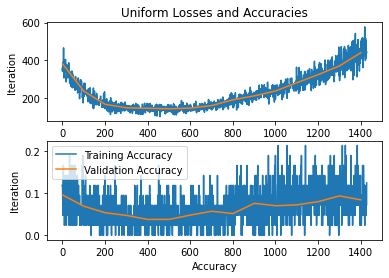

In [87]:
# Go back up and try a few different networks and initialization strategies
# Plot training and validation loss for uniform initialization
# Plot training and validation accuracy for uniform initialization
a, b = zip(*validation_losses)
c, d = zip(*validation_accuracy)
fig = plt.figure()

ax = fig.add_subplot(211)
ax.plot(range(len(train_losses)), train_losses, label='Training Loss')
ax.plot(a, b, label='Validation Loss')
ax.set_ylabel("Iteration")
ax.set_xlabel("Loss Value")
ax.set_title("Uniform Losses and Accuracies")

ax = fig.add_subplot(212)
ax.plot(range(len(train_accuracy)), train_accuracy, label='Training Accuracy')
ax.plot(c, d, label='Validation Accuracy')
ax.set_ylabel("Iteration")
ax.set_xlabel("Accuracy")

plt.legend()
plt.show()

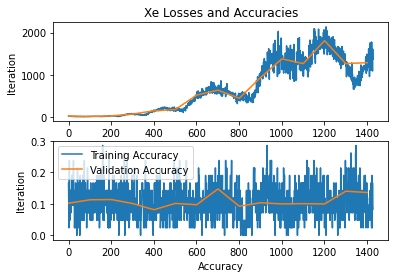

In [88]:
# Plot training and validation loss for Xe initialization
# Plot training and validation accuracy for Xe initialization
a, b = zip(*validation_lossesXe)
c, d = zip(*validation_accuracyXe)
fig = plt.figure()

ax = fig.add_subplot(211)
ax.plot(range(len(train_lossesXe)), train_lossesXe, label='Training Loss')
ax.plot(a, b, label='Validation Loss')
ax.set_ylabel("Iteration")
ax.set_xlabel("Loss Value")
ax.set_title("Xe Losses and Accuracies")

ax = fig.add_subplot(212)
ax.plot(range(len(train_accuracyXe)), train_accuracyXe, label='Training Accuracy')
ax.plot(c, d, label='Validation Accuracy')
ax.set_ylabel("Iteration")
ax.set_xlabel("Accuracy")

plt.legend()
plt.show()


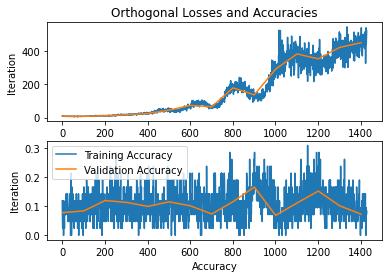

In [89]:
# Plot training and validation loss for orthogonal initialization
# Plot training and validation accuracy for orthogonal initialization
a, b = zip(*validation_lossesOr)
c, d = zip(*validation_accuracyOr)
fig = plt.figure()

ax = fig.add_subplot(211)
ax.plot(range(len(train_lossesOr)), train_lossesOr, label='Training Loss')
ax.plot(a, b, label='Validation Loss')
ax.set_ylabel("Iteration")
ax.set_xlabel("Loss Value")
ax.set_title("Orthogonal Losses and Accuracies")

ax = fig.add_subplot(212)
ax.plot(range(len(train_accuracyOr)), train_accuracyOr, label='Training Accuracy')
ax.plot(c, d, label='Validation Accuracy')
ax.set_ylabel("Iteration")
ax.set_xlabel("Accuracy")

plt.legend()
plt.show()


In [90]:
# Compute and print the number of parameters in the model
print("\nParameters:", np.sum([np.prod(p.size()) for p in model.parameters()]))


Parameters: 79420


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernal_size=(3, 3), padding=(1, 1))**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **(out_channels=65, kernal_size=(3, 3), padding=(1, 1))**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **(out_channels=7, kernal_size=(3, 3), padding=(0, 0))**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernal_size=(5, 5), padding=(0, 0))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernal_size=(5, 5), padding=(0, 0))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernal_size=(5, 5), padding=(0, 0))**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernal_size=(5, 3), padding=(1, 1))**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernal_size=(5, 3), padding=(0, 0))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernal_size=(5, 3), padding=(1, 1))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernal_size=(5, 3), padding=(0, 0))**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **(out_channels=10, kernal_size=(1, 1), padding=(0, 0))**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernal_size=(1, 1), padding=(0, 0))**

**TODO:**

* Answer all the questions above 

**DONE:**


In [94]:
# Write some test code for checking the answers for these problems (example shown in the video)
c = nn.Conv2d(3, 10, kernel_size=(3, 3), padding=(0, 0))
c(torch.zeros(1, 3, 10, 10)).size()

torch.Size([1, 10, 8, 8])